In [211]:
import os
import re
import random
import numpy as np
import pandas as pd
import multiprocessing
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline
plt.style.use('ggplot')

DATA_PATH = '../../DataLake/bidmc_csv'
DATA_SAVE_PATH = '/root/Workspace/Project-RRpo-2ndStudy/dataset' 
regex_bidmc = re.compile('bidmc_[0-9]+')

In [2]:
def interpolation(x, input):
    x0 = int(np.floor(x))
    y0 = input[x0]
    x1 = int(np.ceil(x))
    y1 = input[x1]
    y = (y1-y0)*(x-x0) + y0
    return y


def gen_signal(A=1, f=1, phi=0, k=1, t=360):
    t = np.linspace(0,k,t)
    return A*np.cos(2*np.pi*f*t + phi)


def plot_sig(sig):
    plt.figure(figsize=(20,3))
    plt.plot(sig)
    plt.show()


def get_resp_class(dataset):
    rapid_rr = []; normal_rr = []; slow_rr = []
    for id, samples in dataset:
        for sample in samples:
            if sample[1] < 12: slow_rr.append(sample)
            elif sample[1] > 20: rapid_rr.append(sample)
            else: normal_rr.append(sample)
    
    rapid_rr = np.array(rapid_rr)
    normal_rr = np.array(normal_rr)
    slow_rr = np.array(slow_rr)
    return rapid_rr, normal_rr, slow_rr


def get_trainable_X(dataset):
    scaler = MinMaxScaler()
    return np.expand_dims(scaler.fit_transform(np.vstack(dataset[:, 0])),axis=-1)


def get_predict_performance(model, X, y):
    y_pred = model.predict(X)
    return y - y_pred


def signal_resample(input_signal, org_fs, new_fs, method='interpolation'):
    output_signal = []
    new_x = np.arange(0, len(input_signal), org_fs/new_fs)
    
    if method == 'interpolation': 
        interp = interpolation

    for x in new_x:
        y = interp(x, input_signal)
        output_signal.append(y)

    return np.array(output_signal)


def generate_dataset(arg_pleth, arg_resp, org_fs=125, new_fs=30, shift_factor=4):
    window_size = org_fs * 60 # 7500
    shift = int(window_size/shift_factor) # 125
    shift_n_times = int((len(arg_pleth)-window_size)/shift)+1

    window_pleth = np.array([arg_pleth[0+shift*i:window_size+shift*i] for i in range(shift_n_times)])
    window_rsmp_pleth = np.array([signal_resample(win, org_fs, new_fs) for win in window_pleth])
    window_resp = np.round(np.mean([arg_resp[0+(shift//org_fs)*i:(window_size//org_fs)+(shift//org_fs)*i] for i in range(shift_n_times)], axis=-1)).astype(np.int32).reshape(-1,1)
    dataset = np.array([np.array([window_rsmp_pleth[i], window_resp[i][0]], dtype=object) for i in range(len(window_pleth))])
    return dataset


def preprocessing(filepath, id, numtaps, cutoff, shift_factor, org_fs, new_fs, noisy=False, A=1, f=1, phi=0, k=1, t=360):
    pleth = pd.read_csv(f'{filepath}/{id}_Signals.csv', usecols=['Time [s]', ' PLETH'])[' PLETH'].values
    resp = pd.read_csv(f'{filepath}/{id}_Numerics.csv', usecols=['Time [s]', ' RESP'])[' RESP'].values

    if np.isnan(resp).sum() != 0:
        print(id)
        return id, None
    
    if noisy:
        syn_sig1 = gen_signal(A=A, f=f, phi=phi, k=k, t=t).reshape(-1,1)
        noise_power1 = np.square(syn_sig1).mean()
        signal_power = np.square(pleth).mean()
        print(f'SNR:{10*np.log10(signal_power/noise_power1)}')
        pleth = pleth.reshape(-1,1) + syn_sig1
        pleth = pleth.reshape(-1)

    taps = signal.firwin(numtaps=numtaps, cutoff=cutoff, window='hamming', pass_zero=False, fs=org_fs)
    pleth = signal.filtfilt(taps, 1.0, pleth)

    dataset = generate_dataset(pleth, resp, org_fs=org_fs, new_fs=new_fs, shift_factor=shift_factor)
    print(f'{id} --> {dataset.shape}')
    return id, dataset

In [3]:
bidmc_test = np.load(f'../dataset/test_dataset/bidmc-test_dataset.npy', allow_pickle=True)
bidmc_id = bidmc_test[:, 0]

In [4]:
test_idx = np.random.choice(len(bidmc_id))
pleth = pd.read_csv(f'{DATA_PATH}/{bidmc_id[test_idx]}_Signals.csv', usecols=['Time [s]', ' PLETH'])[' PLETH'].values.reshape(-1,1)
resp = pd.read_csv(f'{DATA_PATH}/{bidmc_id[test_idx]}_Numerics.csv', usecols=['Time [s]', ' RESP'])[' RESP'].values

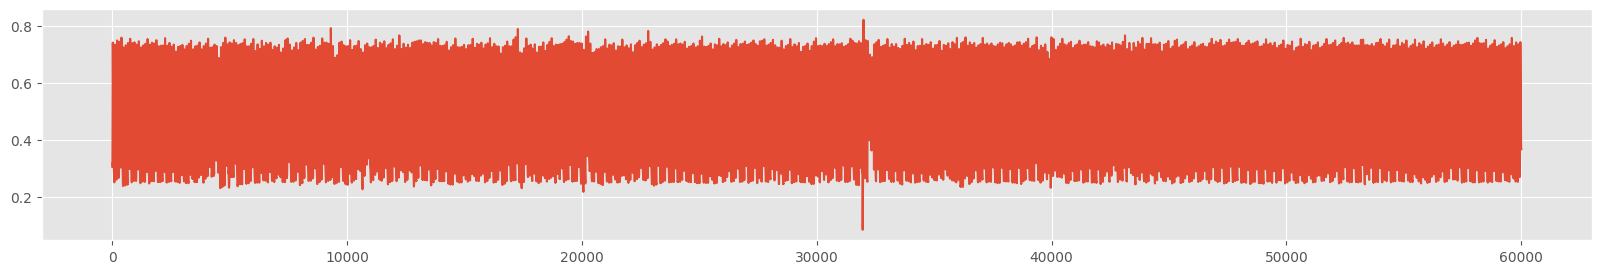

0.19916682817021264


In [5]:
plot_sig(pleth)
signal_power = np.square(pleth).mean()
print(signal_power)

In [128]:
syn_sig1 = gen_signal(A=0.065, f=0.7, phi=0, k=20, t=60001).reshape(-1,1)
syn_sig2 = gen_signal(A=0.118, f=1.0, phi=0, k=30, t=60001).reshape(-1,1)
syn_sig3 = gen_signal(A=0.210, f=2.0, phi=0, k=10, t=60001).reshape(-1,1)
# plot_sig(syn_sig1)
noise_power1 = np.square(syn_sig1).mean()
noise_power2 = np.square(syn_sig2).mean()
noise_power3 = np.square(syn_sig3).mean()
print(noise_power1)
print(noise_power2)
print(noise_power3)

0.0021125352077465374
0.006962116031399476
0.0220503674938751


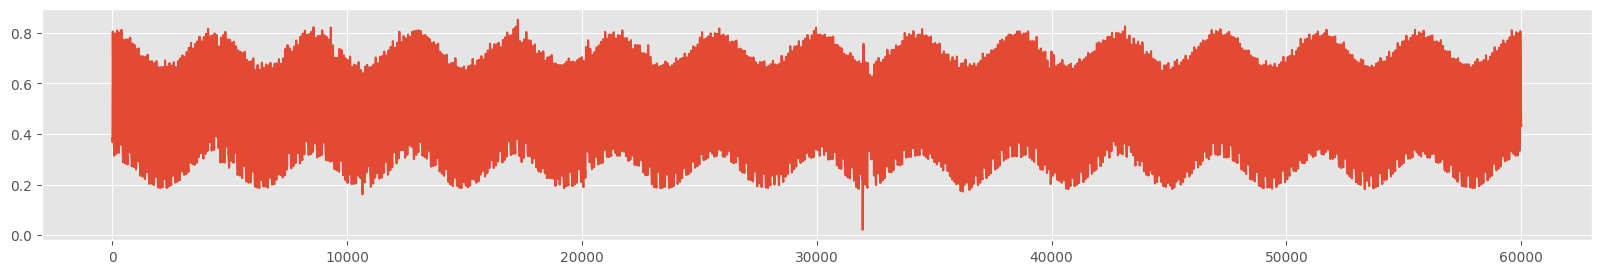

SNR:19.744130513860867


In [129]:
plot_sig(pleth + syn_sig1)
print(f'SNR:{10*np.log10(signal_power/noise_power1)}')

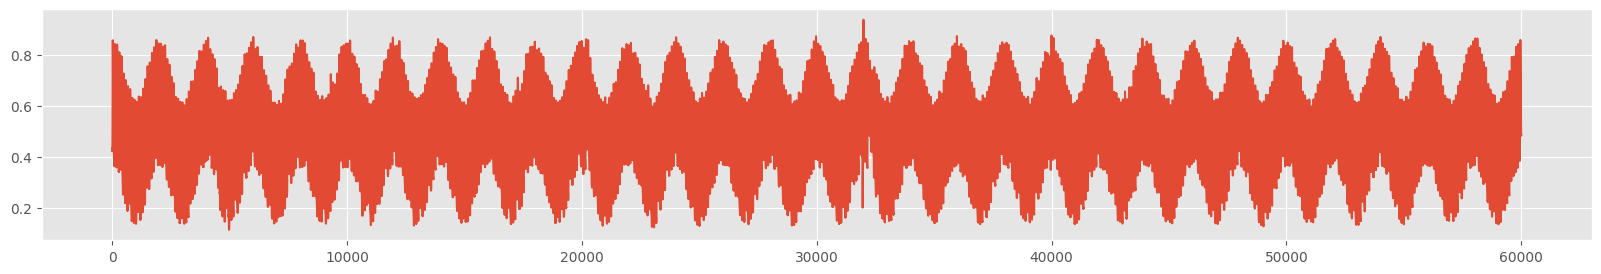

SNR:14.564757500595471


In [130]:
plot_sig(pleth + syn_sig2)
print(f'SNR:{10*np.log10(signal_power/noise_power2)}')

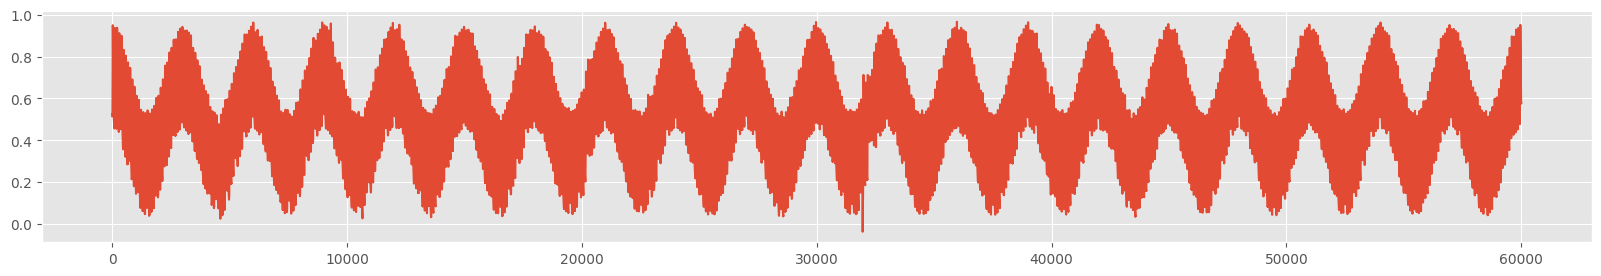

SNR:9.558011752039594


In [131]:
plot_sig(pleth + syn_sig3)
print(f'SNR:{10*np.log10(signal_power/noise_power3)}')

In [203]:
pleth_org = preprocessing(DATA_PATH, bidmc_id[test_idx], 2000, [0.1, 0.4], 60, 125, 30, noisy=False)
pleth_snr20 = preprocessing(DATA_PATH, bidmc_id[test_idx], 2000, [0.1, 0.4], 60, 125, 30, noisy=True, A=0.065, f=0.7, phi=0, k=20, t=60001) #A=0.065, f=0.7, phi=0, k=20
pleth_snr15 = preprocessing(DATA_PATH, bidmc_id[test_idx], 2000, [0.1, 0.4], 60, 125, 30, noisy=True, A=0.118, f=1.2, phi=0, k=30, t=60001) #A=0.118, f=1.2, phi=0, k=30
pleth_snr10 = preprocessing(DATA_PATH, bidmc_id[test_idx], 2000, [0.1, 0.4], 60, 125, 30, noisy=True, A=0.210, f=2.5, phi=0, k=20, t=60001) #A=0.210, f=2.5, phi=0, k=20

bidmc_06 --> (421, 2)
SNR:19.744130513860867
bidmc_06 --> (421, 2)
SNR:14.564757500595471
bidmc_06 --> (421, 2)
SNR:9.558011752039594
bidmc_06 --> (421, 2)


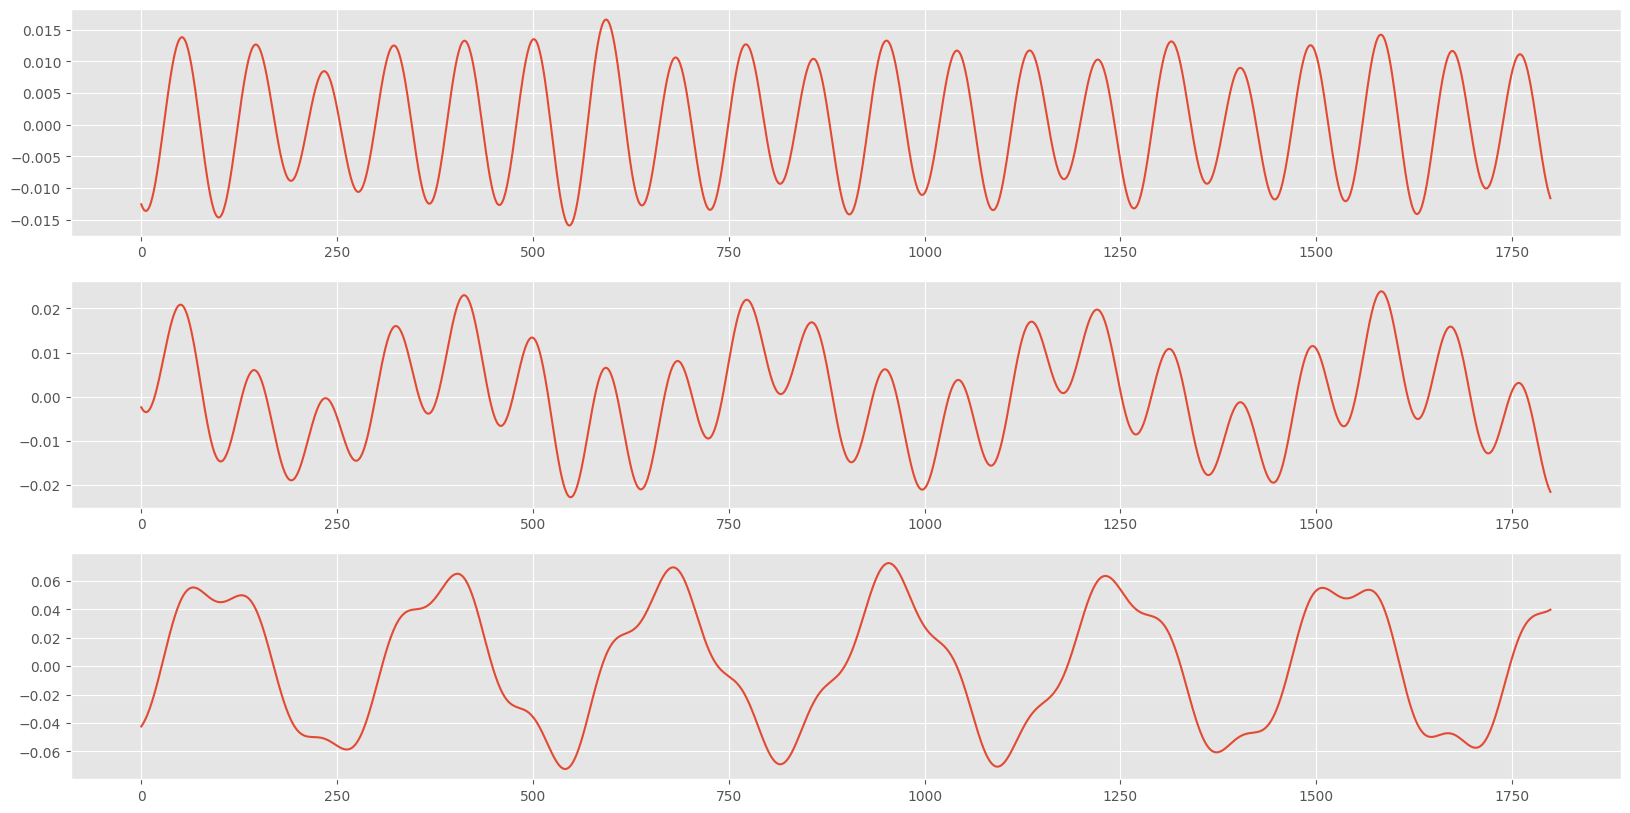

In [204]:
fig, axs = plt.subplots(3,1,figsize=(20,10))
axs[0].plot(pleth_snr20[1][400,0])
axs[1].plot(pleth_snr15[1][400,0])
axs[2].plot(pleth_snr10[1][400,0])
plt.show()

In [205]:
pleth_snr20[1].shape

(421, 2)

## Model

In [206]:
import tensorflow as tf
import keras
from model_src.BianResnet import BianResNet 
from model_src.DilatedResNet import DilatedResNet
from model_src.RespNet import RespNet

In [207]:
test_bian = BianResNet()
test_bian.load_weights(f'../models/230924/bidmc/Bian/Bian-bidmc-KF5/ckpt')
test_bian.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)

test_dilres = DilatedResNet(num_of_blocks=4, kernel_size=2, dilation_rate=3, dwn_kernel_size=3, filters=8, strides_of_avg=2, units=86)
test_dilres.load_weights(f'../models/230924/bidmc/DilatedResNet/DilatedResNet-bidmc-KF5/ckpt')
test_dilres.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)

test_respnet = RespNet()
test_respnet.load_weights(f'../models/230924/bidmc/RespNet/RespNet-bidmc-KF5/ckpt')
test_respnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=keras.metrics.MeanAbsoluteError()
)

In [208]:
X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_org[1]), pleth_org[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_bian, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_snr20[1]), pleth_snr20[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_bian, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_snr15[1]), pleth_snr15[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_bian, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_snr10[1]), pleth_snr10[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_bian, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

(421, 1800, 1) (421, 1)


14/14 [==============================] - 1s 7ms/step
0.7203 ± 0.2655
(421, 1800, 1) (421, 1)
14/14 [==============================] - 0s 7ms/step
0.7304 ± 0.2729
(421, 1800, 1) (421, 1)
14/14 [==============================] - 0s 7ms/step
1.4932 ± 0.4728
(421, 1800, 1) (421, 1)
14/14 [==============================] - 0s 7ms/step
2.2513 ± 0.4843


In [209]:
X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_org[1]), pleth_org[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_dilres, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_snr20[1]), pleth_snr20[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_dilres, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_snr15[1]), pleth_snr15[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_dilres, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_snr10[1]), pleth_snr10[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_dilres, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

(421, 1800, 1) (421, 1)
14/14 [==============================] - 1s 10ms/step
0.6303 ± 0.3197
(421, 1800, 1) (421, 1)
14/14 [==============================] - 0s 8ms/step
0.6417 ± 0.3258
(421, 1800, 1) (421, 1)
14/14 [==============================] - 0s 7ms/step
0.8123 ± 0.3744
(421, 1800, 1) (421, 1)
14/14 [==============================] - 0s 9ms/step
4.1142 ± 0.4804


In [210]:
X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_org[1]), pleth_org[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_respnet, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_snr20[1]), pleth_snr20[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_respnet, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_snr15[1]), pleth_snr15[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_respnet, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

X_bidmc_np_test, y_bidmc_np_test = get_trainable_X(pleth_snr10[1]), pleth_snr10[1][:, 1].reshape(-1,1)
print(X_bidmc_np_test.shape, y_bidmc_np_test.shape)
err_bian_test = get_predict_performance(test_respnet, X_bidmc_np_test, y_bidmc_np_test)
print(f'{np.mean(np.abs(err_bian_test)):.4f} ± {np.std(np.abs(err_bian_test)):.4f}')

(421, 1800, 1) (421, 1)
14/14 [==============================] - 3s 28ms/step
0.7122 ± 0.3290
(421, 1800, 1) (421, 1)
14/14 [==============================] - 0s 27ms/step
0.7265 ± 0.3328
(421, 1800, 1) (421, 1)
14/14 [==============================] - 0s 27ms/step
2.0491 ± 0.4456
(421, 1800, 1) (421, 1)
14/14 [==============================] - 0s 27ms/step
2.5544 ± 0.3368
